<a href="https://colab.research.google.com/github/KhuramC/Fear-Lesson-Plans/blob/master/D2/D2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cell spikes 37 time(s)


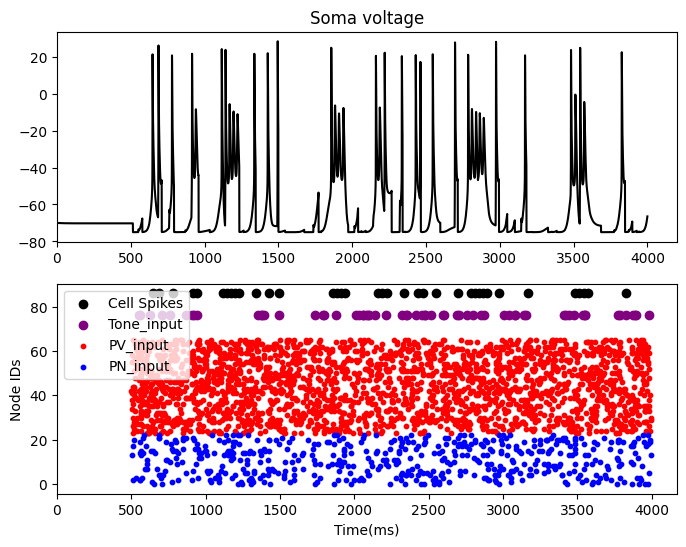

In [1]:
#@title Run Cell to activate model
import os, sys
from io import StringIO
RunningInCOLAB = 'google.colab' in str(get_ipython())
print("Downloading model this will only take a min!")
class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout


with Capturing() as output:
  if RunningInCOLAB:

    print('Downloading packages')
    !pip install ipywidgets &> /dev/null
    !pip install neuron &> /dev/null
    !pip install bmtk &> /dev/null

  if os.path.basename(os.getcwd())!='D2':
    !git clone https://github.com/KhuramC/Fear-Lesson-Plans.git
    %cd Fear-Lesson-Plans/D2
    !nrnivmodl modfiles
    %ls
    print("model was downloaded!")
  else:
    print("model was already downloaded")

from neuron import h,nrn
import matplotlib.pyplot as plt
from neuron.units import ms, mV
import ipywidgets as widgets
from ipywidgets import interactive_output,HBox,VBox,Label,Layout
from IPython.display import display
from IPython.display import clear_output
from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator
import numpy as np
import pandas as pd
import math


def lognorm(mean,std): #lognorm distribution function based on given mean and std
    mean = float(mean)
    std = float(std)
    mean_ = np.log(mean) - 0.5 * np.log((std/mean)**2+1)
    std_ = np.sqrt(np.log((std/mean)**2 + 1))
    return float(np.random.lognormal(mean_,std_))

%matplotlib inline


def new_jitter(arr,max_jitter): #jitters the input(makes it much noisier based on some max jitter)
    for i in range(len(arr)):
        jitter = np.random.randint(low=(max_jitter*-1), high=max_jitter,size=1,dtype=int)
        jitter = jitter/1000
        arr[i] = arr[i] + jitter
    return arr

def alter_spikes(PN_psg,i,exc_syn_num, inh_gap, max_jitter): #old version
  spikes = PN_psg.get_times(node_id = i %(exc_syn_num)) #ensures that we access a valid spike train originally made for the exc syn.
  repeats = math.floor(i/exc_syn_num) #how many times we have repeated using spike trains
  if(repeats == 0): #if first time, just need to add the inh_gap
    altered_spikes = spikes + inh_gap
  else:
    altered_spikes = new_jitter(spikes, max_jitter*(repeats)) #jitters by a factor of 50 for every time we repeat using a spike train
  return altered_spikes


def create_spike_matrix(dt,tstop,offset, syn_num, psg): #function for creating spike matrix from the BMTK Poisson Spike Generator(makes spikes at given timestamps)
    spike_matrix = np.zeros((int((tstop - offset)/dt),syn_num)) #time is [range of spike interval]  * how precise dt is.
    for syn in range(np.shape(spike_matrix)[1]): #syn is columns
        spikes = np.round(psg.get_times(node_id = syn),1) #gets spike times for a given train and rounds to nearest tenth for dt
        spike_index = 0
        if(spikes.size == 0): #if the syn has no spikes, go to next synapse.
          continue
        for time in range(np.shape(spike_matrix)[0]): #time is rows
            #at row index i, the value of t is dt(i) + offset
            if(spikes[spike_index] == (time*dt + offset)): #if there is a spike at the given time we are looking at
                spike_index += 1 #increment spike_index
                spike_matrix[time,syn] = 1 #states that there is a spike there
                if(spike_index == spikes.size): #if we are here, we've gone through all the spikes that the syn does, so just go to next synapse.
                  break

    return spike_matrix


def shift_wrap_array(arr, by): #from Walt's notebook
    wrap = arr[-by:].copy()
    arr[by:] = arr[0:-by]
    arr[0:by] = wrap
    return arr


def create_firing_rates(dt,tstop,offset,exc_syn_num,PN_psg,inh_gap): #Created to simplify the process
    spike_matrix = create_spike_matrix(dt,tstop,offset,exc_syn_num,PN_psg)
    exc_spike_prob = np.mean(spike_matrix, axis = 1) #gets average across every row, or every timestep
    inh_spike_prob = shift_wrap_array(exc_spike_prob, int(inh_gap)) #function created by Walt in delayed spike train notebook

    exc_firing_rate = -np.log(1 - exc_spike_prob) # from formula by Walt's delayed spike train notebook
    inh_firing_rate = -np.log(1 - inh_spike_prob) # from formula by Walt's delayed spike train notebook
    return exc_firing_rate, inh_firing_rate


def inhomogeneous_poisson_through_num_points_for_window_one(lambdas): #from Walt's notebook
    t = np.zeros(len(lambdas))
    for i, lambd in enumerate(lambdas):
        num_points = np.random.poisson(lambd)
        if num_points > 0: t[i] = 1
    return t



def convert_spike_trains(firing_rate,dt,offset):
  spikes = np.empty(0)
  for i in range(firing_rate.size):
    if(firing_rate[i] == 1): #i.e. if there is a spike at this time
      spikes = np.append(spikes,(i*dt+offset)) #then add that timestamp to the array
  return spikes

def pn(fr_tone): #given the firing_rate of tone, what is the firing rate of PNs? from walt's notebook
    return 20.0305 + (0.5 - 20.0305) / (1 + (fr_tone / 19.76273) ** 9.162564)

def pv(fr_tone): #given the firing_rate of tone, what is the firing rate of PVs? from walt's notebook
    return 56.2732 + (5 - 56.2732) / (1 + (fr_tone / 25.29061) ** 4.297946)


#shifts the firing rate based on tone frequency and creates spike vector(needs to be reconverted to timestamp ver)
def create_spikes(tone_frequency, firing_rate, type = 'PN') -> None:
  shift = 0
  if(type == 'PN'):
    spikes = inhomogeneous_poisson_through_num_points_for_window_one(firing_rate)
  elif(type == 'PV'):
    shift = pv(tone_frequency)
    #print(shift)
    spikes = inhomogeneous_poisson_through_num_points_for_window_one(firing_rate + ((shift/10000) - np.mean(firing_rate))) #shifts firing rate based on tone.
  else:
    raise(ValueError(f"{type} should be 'PN' or 'PV'."))

  return spikes




h.load_file('stdrun.hoc')
h.load_file('PN_cells.hoc') #reads in template
def model(tone_frequency,tone2PN_mean,PV2PN_mean,tone2PN_std,PV2PN_std,exc_shift):
    dt = 0.1
    tstop = 4000
    offset = 500 # delay is another word;
    h.dt = dt # time step (resolution) of the simulation in ms
    h.tstop = tstop # how long to run the simulation in ms
    h.v_init= -70 # initial membrane potential in mV
    inh_gap = 4 # gap between PN2PN and PV2PN spikes

    cell = h.PN_C() #cell from template file

    exc_syn_num = 23 # from amygdala paper
    inh_syn_num = 43 # from amygdala paper
    max_jitter = 3 #just decided on a whim




    #Excitatory Spike Train
    PN_psg = PoissonSpikeGenerator(population='Synapses')
    PN_psg.add(
    node_ids=range(exc_syn_num),  # Have a spike train for every PN2PN input
    firing_rate=pn(tone_frequency),    #function for excitatory input based on
    times=(0.5, tstop/1000)    # Firing starts at 0.5 s up to end of tstop
    )
    exc_firing_rate, inh_firing_rate = create_firing_rates(dt,tstop,offset, exc_syn_num, PN_psg, inh_gap)



    #PN2PN/Excitatory Synapse
    exc_df = PN_psg.to_dataframe()
    avg_exc_firing_rate = np.empty(0)
    for i in range(exc_syn_num): #for every excitatory synapse(PN2PN):
      conn_exc = h.Exp2Syn(cell.dend[0](0.9)) #create syn on apical dendrite

      spikes_exc = PN_psg.get_times(node_id= i) #original version of creating spike trains
      #spikes = create_spikes(tone_frequency, exc_firing_rate, type = 'PN') # Walt's version of creating spike trains
      #spikes_exc = convert_spike_trains(spikes,dt,offset) #change back to timestamp version of spike train
      #if you do the above version, you need to change the exc_df in terms of storing then plotting spikes, since they are not the same
      avg_exc_firing_rate = np.append(avg_exc_firing_rate, (spikes_exc.size)/((tstop - offset)/1000))


      v_spikes_exc = h.Vector(spikes_exc) #make vector based on the spike train
      vec_stim_exc = h.VecStim() #have vecstim play it
      vec_stim_exc.play(v_spikes_exc)
      nc_exc = h.NetCon(vec_stim_exc,conn_exc,1,1,lognorm(10,0.5)) #make netcon with lognorm weights and spikes  ASK WHAT VALUES THESE SHOULD BE
    #print(f"Excitatory should be {pn(tone_frequency)}")
    #print(f"Average firing_rate for excitatory synapses is {np.mean(avg_exc_firing_rate)} Hz")



    #PV2PN/Inhibitory Synapse
    inh_df = pd.DataFrame(columns =['node_ids','timestamps'])
    avg_inh_firing_rate = np.empty(0)
    for i in range(inh_syn_num): #for every inhibitory synapse(PV2PN):
      conn_inh = h.Exp2Syn(cell.soma[0](0.5)) #create syn on soma
      conn_inh.e = -75

      #np.set_printoptions(threshold = np.inf)

      #altered_spikes = alter_spikes(PN_psg,i,exc_syn_num,inh_gap, max_jitter) #old version
      spikes = create_spikes(tone_frequency,inh_firing_rate,type = 'PV') #Walt's version of creating spike trains
      altered_spikes = convert_spike_trains(spikes,dt,offset) #change back to timestamp version of spike train
      avg_inh_firing_rate = np.append(avg_inh_firing_rate, (altered_spikes.size)/((tstop - offset)/1000))

      vec_spikes_inh = h.Vector(altered_spikes)
      vec_stim_inh = h.VecStim() #make VecStim play it
      vec_stim_inh.play(vec_spikes_inh)
      nc_inh = h.NetCon(vec_stim_inh,conn_inh,1,1,lognorm(PV2PN_mean,PV2PN_std))
      for spike in altered_spikes:  #adds every spike to the df
        new_row = {'node_ids': i+exc_syn_num, 'timestamps': spike}
        #inh_df = inh_df.append(new_row,ignore_index = True)
        #instead of appending, make row into a new df
        row_df = pd.DataFrame([new_row])
        #concat like this
        inh_df = pd.concat([inh_df,row_df],axis = 0, ignore_index= True)

    #print(f"Inhibitory should be {pv(tone_frequency)}")
    #print(f"Average firing_rate for inhibitory synapses is {np.mean(avg_inh_firing_rate)} Hz")



    #Tone
    tone_psg = PoissonSpikeGenerator(population='Tone')
    tone_psg.add(
      node_ids = exc_syn_num+inh_syn_num+10, # only one tone input, higher just to be easier to seen when plotted
      firing_rate=tone_frequency, #user decides tone frequency
      times = (0.5, tstop/1000) #nothing occurs before 0.5s
    )
    try: #if tone_freq is 0 or no spikes occur, this fails, and just spawns an empty df as a result
      tone = tone_psg.get_times(node_id = exc_syn_num+inh_syn_num+10)
      conn_tone = h.Exp2Syn(cell.dend[0](0.9)) #create syn on basal dendrite
      v_spikes_tone = h.Vector(tone) #vector based on spike train
      vec_stim_tone = h.VecStim() #have vecstim play it
      vec_stim_tone.play(v_spikes_tone)
      nc_tone = h.NetCon(vec_stim_tone,conn_tone,1,1,lognorm(tone2PN_mean,tone2PN_std)) #make netcon with lognorm weights and spikes
      tone_df = tone_psg.to_dataframe()
    except:
      tone_df = pd.DataFrame(columns = ['node_ids','timestamps'])





    #Cell_Spikes
    spike_threshold = -15
    cell_spikes = h.Vector()
    nc = h.NetCon(cell.soma[0](0.5)._ref_v, None, sec = cell.soma[0]) #records cell spikes
    nc.threshold = spike_threshold
    nc.record(cell_spikes)


    #Recordings
    t = h.Vector()
    Soma_v = h.Vector()
    t.record(h._ref_t) # derefences and records data
    Soma_v.record(cell.soma[0](0.5)._ref_v)

    h.finitialize(h.v_init * mV)  # runs sims
    h.continuerun(h.tstop * ms)


    #Cell_Spike Manipulations
    np_cell_spikes = np.zeros(len(cell_spikes)) #turns in ndarray
    np_cell_spikes =  cell_spikes.to_python(np_cell_spikes)
    last_node_id = exc_syn_num + inh_syn_num + 20 #to be more visible compared to the other ones
    last_node_ids = np.full(shape = (1,len(cell_spikes)), fill_value= last_node_id)
    print(f"Cell spikes {np_cell_spikes.size} time(s)")



    plot(t,Soma_v,exc_df, inh_df,tone_df,np_cell_spikes, last_node_ids)

def plot(t,Soma_v,exc_df, inh_df,tone_df,np_cell_spikes, last_node_ids):
    fig, ax = plt.subplots(2,1,figsize=(8, 6))
    ax[0].plot(t,Soma_v, color = 'black')
    ax[0].set_xlim(0)
    ax[0].set_title("Soma voltage")
    ax[1].scatter(np_cell_spikes,last_node_ids,color = 'black', label = 'Cell Spikes')
    ax[1].scatter(tone_df['timestamps'],tone_df['node_ids'], color = 'purple', label = 'Tone_input')
    ax[1].scatter(inh_df['timestamps'],inh_df['node_ids'], color = 'red', label = 'PV_input',s = 10)
    ax[1].scatter(exc_df['timestamps'],exc_df['node_ids'], color = 'blue',label = 'PN_input',s = 10)
    ax[1].set_xlim(0)
    ax[1].set_xlabel('Time(ms)')
    ax[1].set_ylabel('Node IDs')
    ax[1].legend(loc = 'upper left')
    plt.show()

#Default values
tone_frequency = 10
tone2PN_mean = 1
PV2PN_mean = 1
tone2PN_std = 0.5
PV2PN_std = 0.5
exc_shift = 0.001


#Widgets
w_run = widgets.Button(description='Run',icon='history',button_style='primary')
w_tone_frequency = widgets.FloatSlider(value=tone_frequency,min=0.001,max=40, step=0.2,description='Tone_freq(Hz)',style=dict(description_width='initial'))
w_tone2PN_mean = widgets.FloatSlider(value=tone2PN_mean,min=0.001,max=100, step=0.2,description='Tone2PN_mean',style=dict(description_width='initial'))
w_PV2PN_mean = widgets.FloatSlider(value=PV2PN_mean,min=0.001,max=100, step=0.2,description='PV2PN_mean',style=dict(description_width='initial'))
w_tone2PN_std = widgets.FloatSlider(value=tone2PN_std,min=0.001,max=100, step=0.2,description='Tone2PN_std',style=dict(description_width='initial'))
w_PV2PN_std = widgets.FloatSlider(value=PV2PN_std,min=0.001,max=100, step=0.2,description='PV2PN_std',style=dict(description_width='initial'))

def run_model(*arges):
    clear_output()  # Removes the sliders and then updated the values and displays the new values
    tone_frequency = w_tone_frequency.value
    tone2PN_mean = w_tone2PN_mean.value
    PV2PN_mean = w_PV2PN_mean.value
    tone2PN_std = w_tone2PN_std.value
    PV2PN_std = w_PV2PN_std.value
    display(ui)
    model(tone_frequency,tone2PN_mean,PV2PN_mean,tone2PN_std,PV2PN_std,exc_shift)

w_run.on_click(run_model)
ui = VBox([HBox([w_run]),
           HBox([w_tone2PN_mean,w_tone2PN_std,w_tone_frequency]),
           HBox([w_PV2PN_mean,w_PV2PN_std])])
ui
